In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def convert_to_df_and_model(train_df, test_df, estimator):
    
    #Filter the DataFrame for the outliers
    train_df_ = train_df[train_df['AV_TOTAL']<np.percentile(train_df['AV_TOTAL'], 92)]
    
    df_train = train_df_
    df_test = test_df
    
    
    #Feature Engineering on Training Set
    categorical_features = df_train.select_dtypes(include = ['object']).columns
    df_train_categorical = df_train[categorical_features]
    df_train_categorical['PTYPE'] = df_train['PTYPE']
    df_train_categorical['YR_BUILT'] = df_train['YR_BUILT']
    df_train_categorical['YR_REMOD'] = df_train['YR_REMOD']
    df_train_categorical['ZIPCODE'] = df_train['ZIPCODE']
    categoricals_to_drop = ['PID','OWNER','ST_NUM','ST_NAME','ST_NAME_SUF','UNIT_NUM',
                            'MAIL_ADDRESS','MAIL CS','MAIL_ZIPCODE', 'LatLong', 'GIS_ID']
    df_train_categorical.drop(categoricals_to_drop, axis = 1, inplace=True)
    df_train_dummied = pd.get_dummies(df_train_categorical)
    
    numeric_features = df_train.select_dtypes(include = ['float64', 'int64']).columns
    df_train_numeric = df_train[numeric_features]
    numeric_drop_list = ['ZIPCODE','GROSS_TAX','AV_TOTAL','AV_LAND', 'AV_BLDG','PTYPE','YR_REMOD','YR_BUILT']
    df_train_numeric.drop(numeric_drop_list, axis = 1, inplace = True)
    
    
    #Feature Engineering on Testing Set
    categorical_features = df_test.select_dtypes(include = ['object']).columns
    df_test_categorical = df_test[categorical_features]
    df_test_categorical['PTYPE'] = df_test['PTYPE']
    df_test_categorical['YR_BUILT'] = df_test['YR_BUILT']
    df_test_categorical['YR_REMOD'] = df_test['YR_REMOD']
    df_test_categorical['ZIPCODE'] = df_test['ZIPCODE']
    categoricals_to_drop = ['PID','OWNER','ST_NUM','ST_NAME','ST_NAME_SUF','UNIT_NUM',
                            'MAIL_ADDRESS','MAIL CS', 'LatLong', 'GIS_ID']
    df_test_categorical.drop(categoricals_to_drop, axis = 1, inplace=True)
    df_test_dummied = pd.get_dummies(df_test_categorical)
    
    numeric_features = df_test.select_dtypes(include = ['float64', 'int64']).columns
    df_test_numeric = df_test[numeric_features]
    numeric_drop_list = ['ZIPCODE','PTYPE','YR_REMOD','YR_BUILT']
    df_test_numeric.drop(numeric_drop_list, axis = 1, inplace = True)
    
    #y_testing = df_test['AV_TOTAL']
    
    
    X_testing_set = pd.concat([df_test_numeric, df_test_dummied], axis = 1)
    X_training_set = pd.concat([df_train_numeric, df_train_dummied], axis = 1)
    X = X_training_set
    y_total = df_train['AV_TOTAL']
    y_tax = df_train['GROSS_TAX']
    y_land = df_train['AV_LAND']
    y_bldg = df_train['AV_BLDG']
    
    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y_total,
                                                        train_size = 0.85,
                                                        random_state = 42)

    #Scale Data
    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)
    
#    print('First, let\'s look at the data')
#    plt.figure(figsize=(10,6))
#    sns.distplot(np.log(train_df[train_df['AV_TOTAL']>0]['AV_TOTAL']))
#    plt.title('Assessed Tax Value')
#    plt.xlabel('log(AV_TOTAL)');
    
#    plt.figure(figsize=(10,6))
#    sns.distplot(np.log(train_df[train_df['GROSS_TAX']>0]['GROSS_TAX']))
#    plt.title('GROSS_TAX')
#    plt.xlabel('log(GROSS_TAX)');
    
#    plt.figure(figsize=(10,6))
#    sns.distplot(np.log(i[i['AV_LAND']>0]['AV_LAND']))
#    plt.title('AV_LAND')
#    plt.xlabel('log(AV_LAND)');
    
#    plt.figure(figsize=(10,6))
#    sns.distplot(np.log(i[i['AV_BLDG']>0]['AV_BLDG']))
#    plt.title('AV_BLDG')
#    plt.xlabel('log(AV_BLDG)');
    
    def runGSAndGetRMSE(est, params):
        gs = GridSearchCV(est, param_grid = params, verbose=0, scoring='r2')
        gs.fit(X_train_ss, y_train)
        print("Your best R^2 score is:",np.sqrt(gs.best_score_))
        print("Your best alpha value is:",gs.best_params_)
        y_pred = gs.predict(X_test_ss)
        
        x = np.linspace(0, max(y_pred), 1000)
        plt.figure(figsize=(8,8))
        plt.title('True Target vs Predicted Target')
        plt.scatter(y_pred,y_test, color = 'r')
        plt.plot(x,x, color = 'black')
        plt.xlabel('Predicted Values')
        plt.ylabel('True Values')
        plt.xlim(0,max(y_pred)+1000)
    
        
        return gs.best_estimator_, gs.best_score_, y_pred
    #Ridge Regression
    ridgeParams = {'alpha':np.linspace(1, 10000, num=10)}
    bestRidgeEst = runGSAndGetRMSE(estimator(), ridgeParams)

In [3]:
train_2008 = pd.read_csv('./train_clean/train_clean_2008.csv')
test_2008 = pd.read_csv('./test_clean/test_clean_2008.csv')
train_2009 = pd.read_csv('./train_clean/train_clean_2009.csv')
test_2009 = pd.read_csv('./test_clean/test_clean_2009.csv')
train_2010 = pd.read_csv('./train_clean/train_clean_2010.csv')
test_2010 = pd.read_csv('./test_clean/test_clean_2010.csv')
train_2011 = pd.read_csv('./train_clean/train_clean_2011.csv')
test_2011 = pd.read_csv('./test_clean/test_clean_2011.csv')
train_2012 = pd.read_csv('./train_clean/train_clean_2012.csv')
test_2012 = pd.read_csv('./test_clean/test_clean_2012.csv')
train_2013 = pd.read_csv('./train_clean/train_clean_2010.csv')
test_2013 = pd.read_csv('./test_clean/test_clean_2010.csv')
train_2014 = pd.read_csv('./train_clean/train_clean_2014.csv')
test_2014 = pd.read_csv('./test_clean/test_clean_2014.csv')
train_2015 = pd.read_csv('./train_clean/train_clean_2015.csv')
test_2015 = pd.read_csv('./test_clean/test_clean_2015.csv')
train_2016 = pd.read_csv('./train_clean/train_clean_2016.csv')
test_2016 = pd.read_csv('./test_clean/test_clean_2016.csv')
train_2017 = pd.read_csv('./train_clean/train_clean_2017.csv')
test_2017 = pd.read_csv('./test_clean/test_clean_2017.csv')
train_2018 = pd.read_csv('./train_clean/train_clean_2018.csv')
test_2018 = pd.read_csv('./test_clean/test_clean_2018.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (12,23,24,25,31,35,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (12,31,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
train_dfs = [train_2008,train_2009,train_2010,train_2011,train_2012,
            train_2013,train_2014,train_2015,train_2016,train_2017,train_2018]

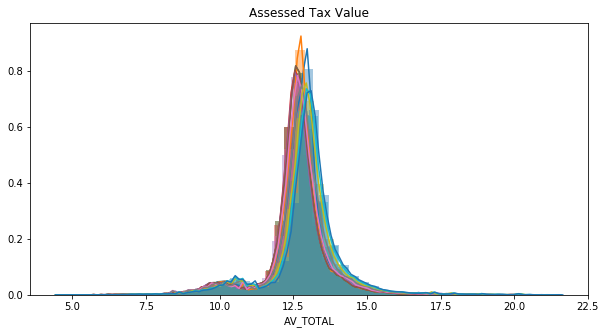

In [25]:
plt.figure(figsize=(10,5))
for i in train_dfs:
    sns.distplot(np.log(i[i['AV_TOTAL']>0]['AV_TOTAL']))
    plt.title('Assessed Tax Value');

In [28]:
np.log(train_2008[train_2008['AV_TOTAL']>0]['AV_TOTAL']).mean()

12.668303854309872

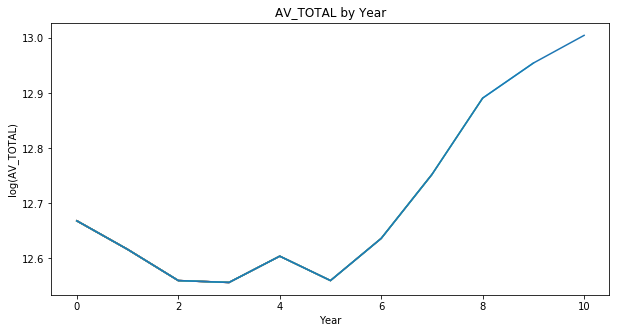

In [33]:
av_total_log_mean = []
plt.figure(figsize = (10,5))
for i in train_dfs:
    av_mean = np.log(i[i['AV_TOTAL']>0]['AV_TOTAL']).mean()
    av_total_log_mean.append(av_mean)
    plt.plot(av_total_log_mean)
    plt.title('AV_TOTAL by Year')
    plt.ylabel('log(AV_TOTAL)')
    plt.xlabel('Year')
    

In [34]:
r2_socres = [0.8223195236570878,0.7978881610736631,0.8241968142997287,
0.8323281736292755, 0.6567208216689282,0.8241968142997287,
0.7472449485865538,0.6228771307522735,0.6125715767636989,
0.5906630700632418, 0.5577937510877418]

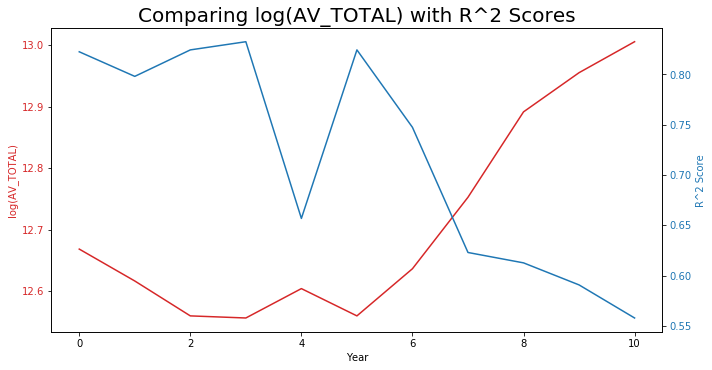

In [54]:
data1 = av_total_log_mean
data2 = r2_socres

fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('log(AV_TOTAL)', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('R^2 Score', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Comparing log(AV_TOTAL) with R^2 Scores', fontsize=20)
plt.show();

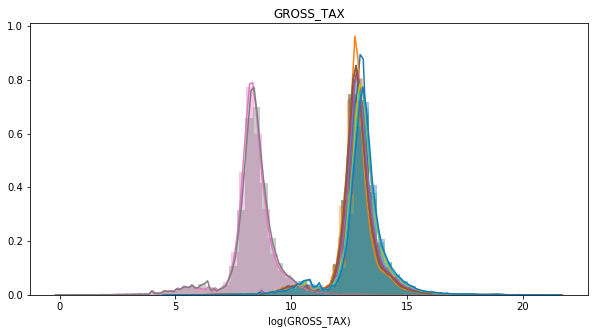

In [63]:
plt.figure(figsize=(10,5))
for i in train_dfs:
    sns.distplot(np.log(i[i['GROSS_TAX']>0]['GROSS_TAX']))
    plt.title('GROSS_TAX')
    plt.xlabel('log(GROSS_TAX)')

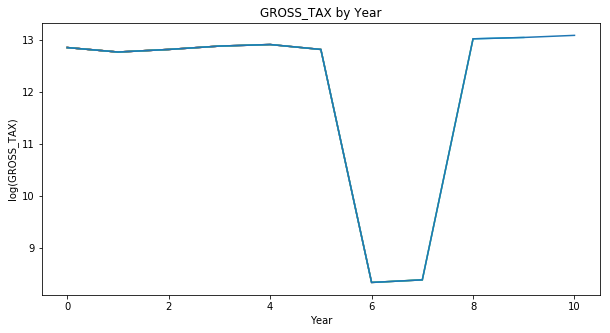

In [66]:
gross_log_mean = []
plt.figure(figsize = (10,5))
for i in train_dfs:
    gross_mean = np.log(i[i['GROSS_TAX']>0]['GROSS_TAX']).mean()
    gross_log_mean.append(gross_mean)
    plt.plot(gross_log_mean)
    plt.title('GROSS_TAX by Year')
    plt.ylabel('log(GROSS_TAX)')
    plt.xlabel('Year')
    

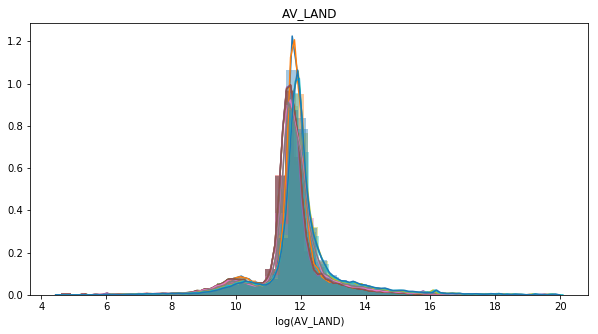

In [68]:
plt.figure(figsize=(10,5))
for i in train_dfs:
    sns.distplot(np.log(i[i['AV_LAND']>0]['AV_LAND']))
    plt.title('AV_LAND')
    plt.xlabel('log(AV_LAND)')

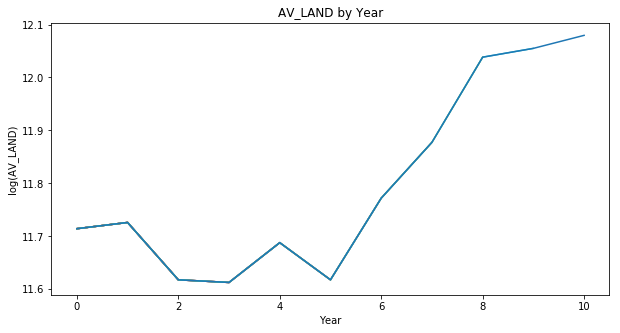

In [71]:
av_land_log_mean = []
plt.figure(figsize = (10,5))
for i in train_dfs:
    av_land_mean = np.log(i[i['AV_LAND']>0]['AV_LAND']).mean()
    av_land_log_mean.append(av_land_mean)
    plt.plot(av_land_log_mean)
    plt.title('AV_LAND by Year')
    plt.ylabel('log(AV_LAND)')
    plt.xlabel('Year');

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


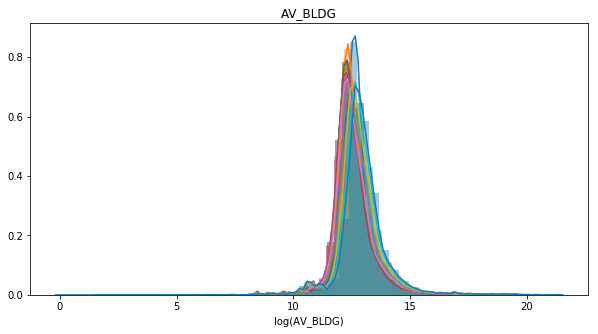

In [73]:
plt.figure(figsize=(10,5))
for i in train_dfs:
    sns.distplot(np.log(i[i['AV_BLDG']>0]['AV_BLDG']))
    plt.title('AV_BLDG')
    plt.xlabel('log(AV_BLDG)')

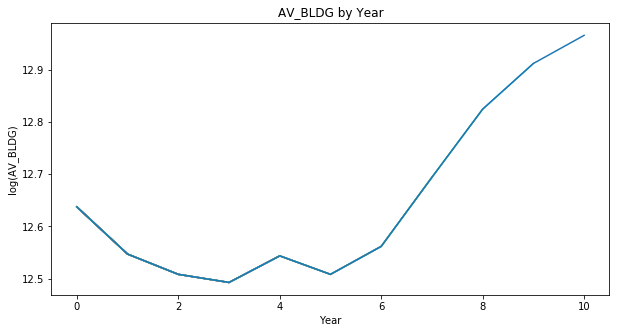

In [74]:
av_bldg_log_mean = []
plt.figure(figsize = (10,5))
for i in train_dfs:
    av_bldg_mean = np.log(i[i['AV_BLDG']>0]['AV_BLDG']).mean()
    av_bldg_log_mean.append(av_bldg_mean)
    plt.plot(av_bldg_log_mean)
    plt.title('AV_BLDG by Year')
    plt.ylabel('log(AV_BLDG)')
    plt.xlabel('Year');

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Your best R^2 score is: 0.8008148394309771
Your best alpha value is: {'alpha': 4445.0}


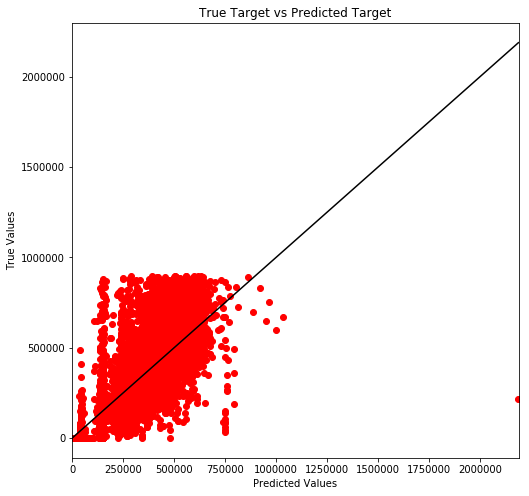

In [13]:
convert_to_df_and_model(train_2008,test_2008,Ridge);

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Your best R^2 score is: 0.7503996392489356
Your best alpha value is: {'alpha': 1.0}


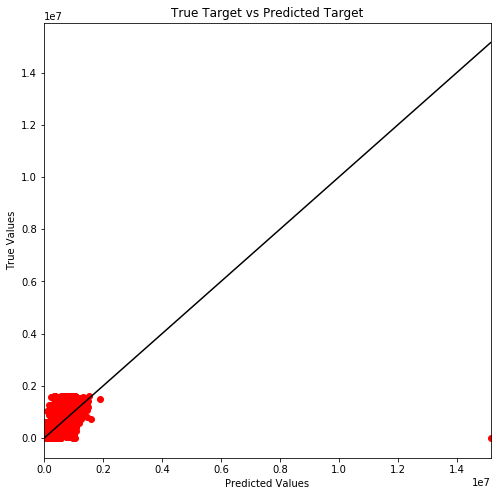

In [14]:
convert_to_df_and_model(train_2018,test_2018,Ridge);

# Clustering?

Let's keep 'LU', 'OWN_OCC', 'R_BLDG_STYL','R_ROOF_TYP', 'R_EXT_FIN', 'R_HEAT_TYP', 'R_AC', 'S_BLDG_STYL',
'S_EXT_FIN', 'U_CORNER', 'U_ORIENT', 'U_HEAT_TYP', 'U_AC','U_KITCH_TYPE', ZIPCODE,OWNER, PTYPE,'YR_REMOD','YR_BUILT'
and then add AV_TOTAL after we've dummied it

In [28]:
train_2008.U_HEAT_TYP.unique()

array(['0', 'W', 'F', 'E', 'P', 'N', 'S', 'O'], dtype=object)

In [46]:
clust_2008 = train_2008[['LU', 'OWN_OCC', 'R_BLDG_STYL','R_ROOF_TYP', 'R_EXT_FIN', 'R_HEAT_TYP', 'R_AC', 
            'S_BLDG_STYL','S_EXT_FIN', 'U_CORNER', 'U_ORIENT', 'U_HEAT_TYP', 'U_AC','U_KITCH_TYPE', 
            'ZIPCODE', 'PTYPE','YR_REMOD','YR_BUILT']]

In [47]:
clust_2008_ = pd.get_dummies(clust_2008)

In [48]:
clust_2008_['AV_TOTAL'] = train_2008['AV_TOTAL']

In [49]:
from sklearn.cluster import KMeans 

In [50]:
#km = KMeans(n_clusters = 10, random_state=42)

#km.fit(clust_2008_)

#clust_2008_['Predictions'] = km.predict(clust_2008_)

#clust_2008_.head()

In [51]:
#centroids = km.cluster_centers_

In [52]:
#centroid_x = []
#centroid_y = []
#for i in range(len(centroids)):
#    centroid_x.append(centroids[i][0])
#    centroid_y.append(centroids[i][1])

In [36]:
#plt.scatter(centroid_x, centroid_y);
#plt.xlabel('X coordinate')
#plt.ylabel('Y coordinate');

Really what I'm seeing here is that there are more likely to be 3 clusters instead of ten?

Let's try that out.

In [53]:
km_ = KMeans(n_clusters = 2, random_state=42)

km_.fit(clust_2008_)

clust_2008_['Predictions'] = km_.predict(clust_2008_)

In [54]:
centroids_ = km_.cluster_centers_

In [55]:
centroid_x = []
centroid_y = []
for i in range(len(centroids_)):
    centroid_x.append(centroids_[i][0])
    centroid_y.append(centroids_[i][1])

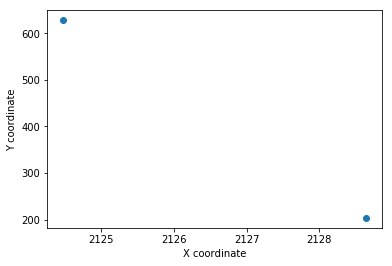

In [56]:
plt.scatter(centroid_x, centroid_y);
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate');

just to check, I want to look at the cosine similarity of the vectors

In [57]:
from scipy.spatial.distance import cosine

In [60]:
a = centroids_[0]
b = centroids_[1]
#c = centroids_[2]

In [61]:
cosine(a,b),cosine(a,c),cosine(b,c), cosine(a,a)

(1.587408509973187e-05, 1.5919071896131065e-05, 3.2392644122580805e-11, 0.0)

they're all very similar...

Alright let's separate these clusters into different dataframes and then look for their change over time :)

In [62]:
cluster_1 = clust_2008_[clust_2008_.Predictions == 0]
cluster_2 = clust_2008_[clust_2008_.Predictions == 1]
#cluster_3 = clust_2008_[clust_2008_.Predictions == 2]

In [63]:
len(cluster_1),len(cluster_2),len(cluster_3)

(119676, 51, 3)

That Didn't really work out as planned - lets try and do this by things ptype

In [69]:
train_2008.PTYPE.value_counts().head()

102    40411
101    23402
104    13692
105    10912
995     5317
Name: PTYPE, dtype: int64

We'll look at those top 5 then.

In [70]:
ptype_102 = train_2008[train_2008['PTYPE'] == 102]
ptype_101 = train_2008[train_2008['PTYPE'] == 101]
ptype_104 = train_2008[train_2008['PTYPE'] == 104]
ptype_105 = train_2008[train_2008['PTYPE'] == 105]
ptype_995 = train_2008[train_2008['PTYPE'] == 995]

In [74]:
len(ptype_102.ZIPCODE.unique())

58

In [94]:
len(ptype_102)

40411

In [75]:
len(ptype_101.ZIPCODE.unique())

32

In [95]:
len(merge_10)

7922

In [92]:
merge_1 = pd.merge(ptype_102, train_2009[['PID','AV_TOTAL']], on = 'PID') 
merge_1.rename({'AV_TOTAL_x': 'AV_TOTAL_2008','AV_TOTAL_y': 'AV_TOTAL_2009'},inplace = True, axis = 1)
merge_2 = pd.merge(merge_1, train_2010[['PID','AV_TOTAL']], on = 'PID') 
merge_2.rename({'AV_TOTAL': 'AV_TOTAL_2010'},inplace = True, axis = 1)
merge_3 = pd.merge(merge_2, train_2011[['PID','AV_TOTAL']], on = 'PID')
merge_3.rename({'AV_TOTAL': 'AV_TOTAL_2011'},inplace = True, axis = 1)
merge_4 = pd.merge(merge_3, train_2012[['PID','AV_TOTAL']], on = 'PID') 
merge_4.rename({'AV_TOTAL': 'AV_TOTAL_2012'},inplace = True, axis = 1)
merge_5 = pd.merge(merge_4, train_2013[['PID','AV_TOTAL']], on = 'PID') 
merge_5.rename({'AV_TOTAL': 'AV_TOTAL_2013'},inplace = True, axis = 1)
merge_6 = pd.merge(merge_5, train_2014[['PID','AV_TOTAL']], on = 'PID') 
merge_6.rename({'AV_TOTAL': 'AV_TOTAL_2014'},inplace = True, axis = 1)
merge_7 = pd.merge(merge_6, train_2015[['PID','AV_TOTAL']], on = 'PID') 
merge_7.rename({'AV_TOTAL': 'AV_TOTAL_2015'},inplace = True, axis = 1)
merge_8 = pd.merge(merge_7, train_2016[['PID','AV_TOTAL']], on = 'PID') 
merge_8.rename({'AV_TOTAL': 'AV_TOTAL_2016'},inplace = True, axis = 1)
merge_9 = pd.merge(merge_8, train_2017[['PID','AV_TOTAL']], on = 'PID') 
merge_9.rename({'AV_TOTAL': 'AV_TOTAL_2017'},inplace = True, axis = 1)
merge_10 = pd.merge(merge_9, train_2018[['PID','AV_TOTAL']], on = 'PID') 
merge_10.rename({'AV_TOTAL': 'AV_TOTAL_2018'},inplace = True, axis = 1)

In [79]:
len(train_2008.ZIPCODE.unique())

70